# Assignment 3
## Sign Language Image Classification using Deep Learning

In this assignment you will implement different deep learning networks to classify images of hands in poses that correspond to letters in American Sign Language. The dataset is contained in the assignment zip file, along with some images and a text file describing the dataset. It is similar in many ways to other MNIST datasets.

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (**excluding J and Z which require motion**). The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and **no cases for 9=J or 25=Z because of gesture motions**). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, $pixel_{1}$,$pixel_{2}$….$pixel_{784}$ which represent a single 28x28 pixel image with grayscale values between 0-255.

## Scenario

A client is interested in having you (or rather the company that you work for) investigate whether it is possible to develop an app that would enable American sign language to be translated for people that do not sign, or those that sign in different languages/styles. They have provided you with a labelled data of images related to signs (hand positions) that represent individual letters in order to do a preliminary test of feasibility.

Your manager has asked you to do this feasibility assessment, but subject to a constraint on the computational facilities available.  More specifically, you are asked to do **no more than 100 training runs in total** (including all models and hyperparameter settings that you consider).  

The task requires you to create a Jupyter Notebook to perform 22 steps. These steps involve loading the dataset, fixing data problems, converting labels to one-hot encoding, plotting sample images, creating, training, and evaluating two sequential models with 20 Dense layers with 100 neurons each, checking for better accuracy using MC Dropout, retraining the first model with performance scheduling, evaluating both models, using transfer learning to create a new model using pre-trained weights, freezing the weights of the pre-trained layers, adding new Dense layers, training and evaluating the new model, predicting and converting sign language to text using the best model.

### IMPORTANT
* Train all the models locally on your own machine. No model training should occur on Gradescope (GS).
* After completing the training, upload the trained models' **h5 files** and their training histories along with your notebook to GS.
    * best_dnn_bn_model.h5
    * best_dnn_bn_perf_model.h5
    * best_dnn_selu_model.h5
    * best_mobilenet_model.h5
    * history1
    * history2
    * history1_perf
    * historymb
* To avoid any confusion and poor training on GS, please remember to comment out the training code in your notebook before uploading it to GS.


In [1]:
# import the necessary libraries (TensorFlow, sklearn NumPy, Pandas, and Matplotlib)
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

# Install opencv using "pip install opencv-python" in order to use cv2.
import cv2

**Step0** This test is for checking whether all the required files are submitted. Once you submit all the required files to the autograder, you will be able to pass this step.

**IMPORTANT:** Run this step to determine whether you have created all the required files correctly.

_Points:_ 1

In [2]:
# Don't change this cell code
required_files = ['best_dnn_bn_model.h5','best_dnn_bn_perf_model.h5','best_dnn_selu_model.h5','best_mobilenet_model.h5','history1','history2','history1_perf','historymb']
step0_files = True
for file in required_files:
    if os.path.exists(file) == False:
        step0_files = False
        print("One or more files are missing!")
        break

# The following code is used by the autograder. Do not modify it.   
step0_data = step0_files

grader.check("step00")

### Data Preprocessing

**STEP1** Load the dataset (train and test) using `Pandas` from the CSV file.

_Points:_ 1

In [3]:
# Load the dataset using Pandas from the CSV file
train_df = pd.read_csv('./sign_mnist_train.csv')
test_df = pd.read_csv('./sign_mnist_test.csv')

# The following code is used by the autograder. Do not modify it.
step1_sol = test_df.shape

grader.check("step01")

**STEP2** Examine the data and fix any problems. It is important that you don't have gaps in the number of classes, therefore, check the classes which are not available and shift the labels in order to ensure 24 classes, starting from class 0. In addition, normalize the values of your images in a range of 0 and 1.

_Points:_ 1

In [4]:
# Separate labels and pixel values in training and testing sets
# Check the label
train_df = train_df[(train_df['label'] >= 0) & (train_df['label'] <= 25)]
test_df = test_df[(test_df['label'] >= 0) & (test_df['label'] <= 25)]

# Separate labels and pixel values in training and testing sets
train_labels = train_df.iloc[:,0]
test_labels = test_df.iloc[:,0]
train_images = train_df.iloc[:,1:]
test_images = test_df.iloc[:,1:]

# Shift the label
train_labels = train_labels.apply(lambda x: x-1 if x > 9 else x).values
test_labels = test_labels.apply(lambda x: x-1 if x > 9 else x).values

# Normalize values
train_images = train_images.values/255.0
test_images = test_images.values/255.0

# The following code is used by the autograder. Do not modify it.
step2_sol = (np.max(train_images)-np.min(train_images), np.max(train_labels)-np.min(train_labels), np.max(test_images)-np.min(test_images), np.max(test_labels)-np.min(test_labels))

grader.check("step02")

**STEP3** Convert Labels to One-Hot Encoding both train and test.

_Points:_ 1

In [5]:
from keras.utils import to_categorical
# Convert labels to one-hot encoding
train_labels_encoded = to_categorical(train_labels)
test_labels_encoded = to_categorical(test_labels)

# The following code is used by the autograder. Do not modify it.
step3_sol = (len(np.unique(train_labels_encoded)), len(np.unique(test_labels_encoded)))

grader.check("step03")

**STEP4** Plot one sample image for each letter in the dataset given in the training set. To solve this step you should use the function `imshow` to diplay your images in a similar to the image below.

<center><img src="example_letters.jpg" width=400 height=300/></center>





_Points:_ 0

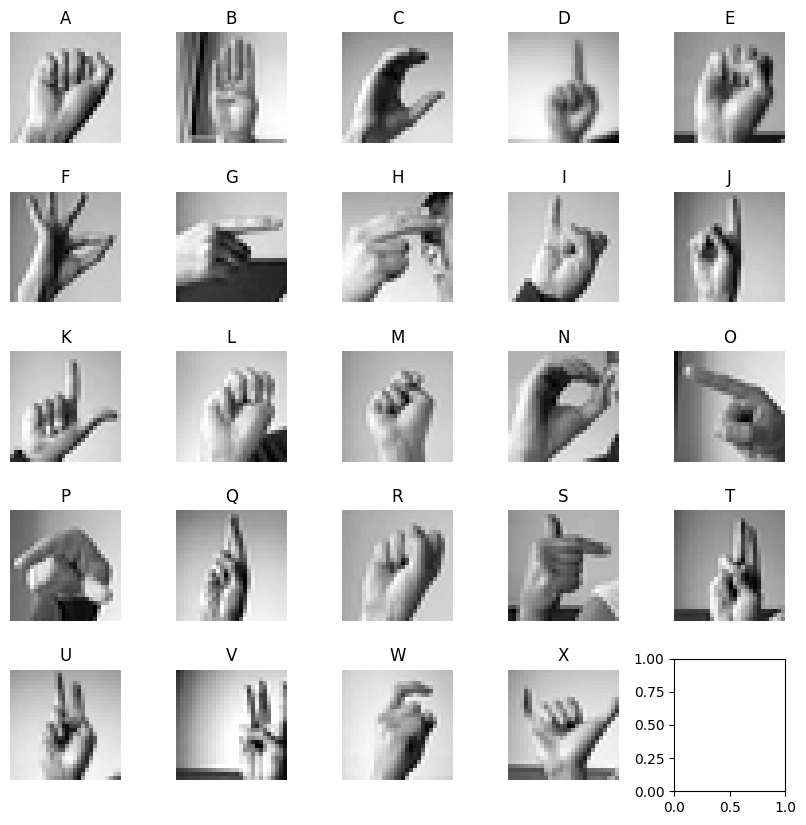

In [6]:
# Get one sample image for each label

# Plot the sample images
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(5, 5, figsize=(10, 10)) # Create 5x5 subplots
axes = axes.ravel() # Flatten axes

classes = np.unique(train_labels) # Get unique classes
for i in np.arange(0, 24): # Plot 24 samples
    # Pick random image for each unique class
    index = random.choice(np.where(train_labels == classes[i])[0])
    img = train_images[index].reshape(28,28)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off') # Turn off axis
    axes[i].set_title(chr(classes[i]+65)) # Set the title of the plot to the corresponding letter
plt.subplots_adjust(wspace=0.5) # Adjust space between subplots


grader.check("step04")

## Create Neural Network Architectures

In this part you should create two different models (model1 and model2) with different architectures.

**STEP5** 
Create one sequential model in `TensorFlow` with 20 Dense layers with 100 neurons each one. Consider the specific modifications that you need to do in order to work with your specific input and those to get the required output. 

* This model uses Batch Normalization in each layer and uses He initialization. Add Swish activation function to each layer.


_Points:_ 5

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import AlphaDropout

# Model 1: with Batch Normalization
model1 = tf.keras.models.Sequential()

# Input Layer
model1.add(Dense(100, input_dim=784, kernel_initializer='he_normal'))
model1.add(BatchNormalization())
model1.add(tf.keras.layers.Activation(swish))

# Hidden Layers
for _ in range(19):
    model1.add(Dense(100, kernel_initializer='he_normal'))
    model1.add(BatchNormalization())
    model1.add(tf.keras.layers.Activation(swish))

# Output Layer
model1.add(Dense(24, activation='softmax'))

model1.summary() # Print model architecture

# The following code is used by the autograder. Do not modify it.
step5_sol = model1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 100)               0

grader.check("step05")

**STEP6** 
Create a second sequential model in `TensorFlow` also with 20 Dense layers with 100 neurons each one. Consider the specific modifications that you need to do in order to work with your specific input and those to get the required output.

In this model you should:
* Replace Batch Normalization with SELU and make necessary adjustments to ensure the network self-normalizes, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers. 
* Regularize this model with Alpha Dropout 0.1.

_Points:_ 5

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import AlphaDropout

# Model 2: with SELU and self-normalization
model2 = tf.keras.models.Sequential()

# Input Layer
model2.add(Dense(100, input_dim=784, activation='selu', kernel_initializer='lecun_normal'))

# Hidden Layers
for i in range(19):
    model2.add(Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    if (i%2) == 0:
        model2.add(AlphaDropout(rate=0.1))

# Output Layer
model2.add(Dense(24, activation='softmax'))

# The following code is used by the autograder. Do not modify it.
step6_sol = model2

grader.check("step06")

## Compile the Models

**STEP7** 
Compile the both previous models using **Nadam** optimization. Also:

* Set the loss function to categorical cross-entropy. 
* Set the metric to accuracy.

_Points:_ 2

In [9]:
# Compile first model
model1.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile second model
model2.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

# The following code is used by the autograder. Do not modify it.
step7_sol = (model1.loss,model2.loss,model1.optimizer.get_config()['name'],model2.optimizer.get_config()['name'])

grader.check("step07")

## Model Training

**STEP8** One of these models work preferably with data, which follow a normal distribution. Generate **train_images_scaled** and **test_images_scaled** using a `Sklearn` function that allow you to convert data to a normal distribution with mean 0 and variance equal 1. 

_Points:_ 2

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.transform(test_images)

# The following code is used by the autograder. Do not modify it.
step8_sol = (np.mean(train_images_scaled),np.mean(test_images_scaled),np.std(train_images_scaled),np.std(test_images_scaled))

grader.check("step08")

**STEP9** Train the two models on the training dataset using early stopping. In order to save the results given by your training for your models, create checkpoints saving the best model in each case using the function `ModelCheckpoint`. Note that one of the models use the scaled data obtained in **STEP8**. Meanwhile, the other model does not. Figure out which is the proper input data for each model.

* Limit the number of epochs to 100. Set the batch size to or greater than 32.

**IMPORTANT:** Comment out the code to train/fit the two models. Keep the code given to save the models.

_Points:_ 3

In [12]:
import pickle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# The following line of code is used by the autograder. Do not modify it.
history1, history2 = None, None
 
# We go to set a seed to get the same results every run
np.random.seed(42)
tf.random.set_seed(42)

# Set up early stopping
early_stopping = EarlyStopping(patience=10)
# Define model checkpoint callback
model1_checkpoint_cb = ModelCheckpoint("best_dnn_bn_model.h5", save_best_only=True)
model2_checkpoint_cb = ModelCheckpoint("best_dnn_selu_model.h5", save_best_only=True)

#################################### Perform the training on your machine and then comment out the following section before uploading it to gradescope. 
# Make sure your best model is named as follows:
# Model1 filename = best_dnn_bn_model.h5
# Model2 filename = best_dnn_selu_model.h5


# Train model 1 (Comment this out before submission)
# history1 = model1.fit(train_images, train_labels_encoded, epochs=100, 
#                       validation_data=(test_images, test_labels_encoded), 
#                       callbacks=[early_stopping, model1_checkpoint_cb],
#                       batch_size=32)

# # Train model 2 (Comment this out before submission)
# history2 = model2.fit(train_images_scaled, train_labels_encoded, epochs=100, 
#                       validation_data=(test_images_scaled, test_labels_encoded), 
#                       callbacks=[early_stopping, model2_checkpoint_cb],
#                       batch_size=32)

# # The following code will save your history - don't change it.
# if 'history1' in globals():  
#     with open('./history1', 'wb') as file_pi:
#         pickle.dump(history1.history, file_pi)
# if 'history2' in globals():  
#     with open('./history2', 'wb') as file_pi:
#         pickle.dump(history2.history, file_pi)
####################################

# The following code is used by the autograder. Do not modify it.
step9_sol = (model1_checkpoint_cb, model2_checkpoint_cb, early_stopping)

Epoch 1/100


2023-05-21 22:24:01.692917: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


858/858 [==============================] - 23s 10ms/step - loss: 2.0031 - accuracy: 0.3786 - val_loss: 2.4683 - val_accuracy: 0.3133
Epoch 2/100
858/858 [==============================] - 8s 9ms/step - loss: 0.7445 - accuracy: 0.7666 - val_loss: 3.3176 - val_accuracy: 0.2312
Epoch 3/100
858/858 [==============================] - 8s 9ms/step - loss: 0.4006 - accuracy: 0.8763 - val_loss: 3.2258 - val_accuracy: 0.3553
Epoch 4/100
858/858 [==============================] - 8s 9ms/step - loss: 0.2927 - accuracy: 0.9117 - val_loss: 3.2077 - val_accuracy: 0.3837
Epoch 5/100
858/858 [==============================] - 9s 11ms/step - loss: 0.2176 - accuracy: 0.9351 - val_loss: 3.8683 - val_accuracy: 0.2876
Epoch 6/100
858/858 [==============================] - 9s 10ms/step - loss: 0.1929 - accuracy: 0.9433 - val_loss: 4.6476 - val_accuracy: 0.2796
Epoch 7/100
858/858 [==============================] - 8s 9ms/step - loss: 0.1610 - accuracy: 0.9524 - val_loss: 4.0623 - val_accuracy: 0.3544
Epoch 8

grader.check("step09")

**STEP10** Using the loaded models obtained from the code given below, evaluate the performance of each model on the test set. While evaluating, make sure to take into account which model uses scaled data and which model does not.

_Points:_ 2

In [13]:
# Do not change the following 4 lines of code.
# define the file name for the saved model
model1_name = "best_dnn_bn_model.h5"
# load the model
model1 = keras.models.load_model(model1_name)
# define the file name for the saved model
model2_name = "best_dnn_selu_model.h5"
# load the model
model2 = keras.models.load_model(model2_name)

# Evaluate the models on the test set
test_loss1, test_acc1 = model1.evaluate(test_images, test_labels_encoded)
test_loss2, test_acc2 = model2.evaluate(test_images_scaled, test_labels_encoded)
print(f"Model 1| Test accuracy: {test_acc1:.4f}, Test loss: {test_loss1:.4f}")
print(f"Model 2| Test accuracy: {test_acc2:.4f}, Test loss: {test_loss2:.4f}")

# The following code is used by the autograder. Do not modify it.
step10_sol = (test_loss1, test_acc1, test_loss2, test_acc2, model1, model2)

225/225 [==============================] - 1s 1ms/step - loss: 1.9384 - accuracy: 0.5343
Model 1| Test accuracy: 0.7142, Test loss: 1.4745
Model 2| Test accuracy: 0.5343, Test loss: 1.9384


grader.check("step10")

**STEP11** From the loaded history of the two trained models, plot a graph of **accuracy** vs **number of epochs** for both training and validation. 

_Points:_ 0

In [14]:
# Load history for model 1 (Do not modify this code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)
    
# Load history for model 2 (Do not modify this code)
history_name2 = "./history2"
with open(history_name2, "rb") as file_pi:
    loaded_history2 = pickle.load(file_pi)

# Plot the training and validation accuracies during training for both models
# The following code is used by the autograder. Do not modify it.
step11_sol = (loaded_history1, loaded_history2)

grader.check("step11")

## MC Dropout

**STEP12** Check if model2 achieves better accuracy using MC Dropout (without retraining).

_Points:_ 3

In [15]:
#This function computes the MC (Monte Carlo) Dropout predictions for a given model and input data. 
# It returns the mean of multiple predictions obtained by running the model in training mode.
#Parameters
#   model: A trained model with a dropout layers.
#   X    : The input data for which the predictions are to be made.
#   n_samples: The number of Monte Carlo samples to generate..
#Returns
  # The function returns an array-like object containing the MC Dropout predictions for the given input data. 
  # The shape of the output should be the same as the model's output layer.
def mc_dropout_predict(model, X, n_samples=10):
    # Write your code here
    y_probas = [model(X, training=True) for sample in range(n_samples)]
    return np.mean(y_probas, axis=0)

# call mc_dropout_predict to Compute the MC Dropout predictions for model 2
output_mc = mc_dropout_predict(model2, test_images_scaled)

output_mc_labels = np.argmax(output_mc, axis=1)

# Compute the accuracy using MC Dropout
accuracy_mc = np.sum(output_mc_labels == test_labels) / len(test_labels)

# Display result.
print(f"Model 2 with MC Dropout: Test accuracy: {accuracy_mc:.4f}")

# The following code is used by the autograder. Do not modify it.
step12_sol = (output_mc, accuracy_mc)

Model 2 with MC Dropout: Test accuracy: 0.5243


grader.check("step12")

## Learning Rate (LR) scheduling

**STEP13** Retrain model1 using performance scheduling and see if it improves training speed and model accuracy.

**IMPORTANT:** Define the model the same way model1 was defined and compile the model the same way as model1.

_Points:_ 2

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam

# Do not modify the following line of code.
history1_perf = None

# Redefine Model 1 so we start again with random weights
model1_perfLRS = keras.models.Sequential()
model1_perfLRS.add(keras.layers.BatchNormalization())
model1_perfLRS.add(keras.layers.Dense(100, input_dim=784, activation='swish', kernel_initializer='he_normal'))
for _ in range(19):
    model1_perfLRS.add(keras.layers.Dense(100, activation='swish', kernel_initializer='he_normal'))
    model1_perfLRS.add(keras.layers.BatchNormalization())
    model1_perfLRS.add(tf.keras.layers.Activation(swish))

model1_perfLRS.add(keras.layers.Dense(24, activation='softmax'))

# Compile the model with Nadam optimizer and categorical cross-entropy loss
model1_perfLRS.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Define the learning rate schedule
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

# Creating model checkpoint to save the best model. 
dnn_bn_perf_checkpoint_cb = ModelCheckpoint("best_dnn_bn_perf_model.h5", save_best_only=True)

#####Perform the training on your machine and then comment out the following section before uploading it to gradescope.
####################################  
# Make sure your best model is named as follows:
# Model1 with performance scheduling filename = best_dnn_bn_perf_model.h5

# Train the model using early stopping and exponential scheduling (Comment this out before submission)
history1_perf = model1_perfLRS.fit(train_images, train_labels_encoded, epochs=100,
                                   validation_data=(test_images_scaled, test_labels_encoded),
                                   callbacks=[early_stopping, dnn_bn_perf_checkpoint_cb, lr_scheduler])

# The following code will save your history - don't change it - comment it out before uploading to GS
if "history1_perf" in globals():
    with open('./history1_perf', 'wb') as file_pi:
        pickle.dump(history1_perf.history, file_pi)
# ####################################
# # The following code is used by the autograder. Do not modify it.
step13_sol = (dnn_bn_perf_checkpoint_cb, lr_scheduler)

Epoch 1/100
858/858 [==============================] - 19s 10ms/step - loss: 3.2554 - accuracy: 0.0581 - val_loss: 113.4710 - val_accuracy: 0.0411 - lr: 0.0010
Epoch 2/100
858/858 [==============================] - 8s 10ms/step - loss: 3.0500 - accuracy: 0.0898 - val_loss: 70.5753 - val_accuracy: 0.0655 - lr: 0.0010
Epoch 3/100
858/858 [==============================] - 8s 10ms/step - loss: 2.8663 - accuracy: 0.1300 - val_loss: 33.3061 - val_accuracy: 0.0878 - lr: 0.0010
Epoch 4/100
858/858 [==============================] - 8s 10ms/step - loss: 2.6158 - accuracy: 0.1746 - val_loss: 29.3374 - val_accuracy: 0.0963 - lr: 0.0010
Epoch 5/100
858/858 [==============================] - 8s 10ms/step - loss: 2.3591 - accuracy: 0.2253 - val_loss: 14.3900 - val_accuracy: 0.0954 - lr: 0.0010
Epoch 6/100
858/858 [==============================] - 8s 10ms/step - loss: 2.0421 - accuracy: 0.3006 - val_loss: 11.7069 - val_accuracy: 0.1344 - lr: 0.0010
Epoch 7/100
858/858 [=============================

grader.check("step13")

**STEP14** Using the loaded model obtained from the code given below, evaluate the performance of the model on the test set.

_Points:_ 1

In [17]:
# Do not change the following 2 lines of code.
# define the file name for the saved model
model_name = "best_dnn_bn_perf_model.h5"
# load the model
model1_perf = keras.models.load_model(model_name)

# Evaluate the model on the test set
test_loss1_perf, test_acc1_perf = model1_perf.evaluate(test_images, test_labels_encoded)
print(f"Model 1 with performance scheduling: Test accuracy: {test_acc1_perf:.4f}")

# The following code is used by the autograder. Do not modify it.
step14_sol = (test_loss1_perf, test_acc1_perf)

225/225 [==============================] - 1s 2ms/step - loss: 1.0344 - accuracy: 0.7607
Model 1 with performance scheduling: Test accuracy: 0.7607


grader.check("step14")

<!-- BEGIN QUESTION -->

**STEP15** From the history of the models loaded using the code given below, plot a graph of **accuracy** vs **number of epochs** for both training and validation.

_Points:_ 0

In [18]:
# load history for model 1 with learning rate scheduling (do not modify the following code)
history_name1_perf = "./history1_perf"
with open(history_name1_perf, "rb") as file_pi:
    loaded_history1_perf = pickle.load(file_pi)

# Load history for the original model1 (do not modify the following code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)

# Plot the training and validation accuracy for both models

grader.check("step15")

<!-- END QUESTION -->

## Transfer learning

Use transfer learning by using a pre-trained **MobileNetV3Small** model on imagenet dataset, and fine-tuning it on the Sign Language MNIST dataset.

**STEP16** First of all, you to prepare your data for this model.
* Reshape your input data (train and test) to (28, 28, 3).
* Standardize your input. 

_Points:_ 2

In [30]:
# Reshape the 1D arrays to (num_samples, 28, 28) and normalize them
train_images_mb = train_images.reshape(-1, 28, 28, 1)
test_images_mb = test_images.reshape(-1, 28, 28, 1)

# Repeat grayscale image 3 times to create a pseudo-RGB image
# train_images_mb = np.repeat(train_images_mb, 3, axis=3)
# test_images_mb = np.repeat(test_images_mb, 3, axis=3)

# Normalize the images to be in range [0, 1]
train_images_mb = train_images_mb / 255.0
test_images_mb = test_images_mb / 255.0

# The following code is used by the autograder. Do not modify it.
step16_sol = (train_images_mb,test_images_mb)

grader.check("step16")

**Step17** Now, we need to define and set up the model. For this you need to follow the next steps:

* Load the pre-trained **MobileNetV3Small** model with weights from ImageNet.
* Freeze the weights of the pretrained layers.
* Modify the input layer to accept inputs of shape (28, 28, 3). 
* Also, add layer `UpSampling2D` to upscale the input by a factor of 2.

Consider that maybe you need to adapt the default output.

_Points:_ 2

In [31]:
from tensorflow.keras.applications import MobileNetV3Small 
from tensorflow.keras.layers import UpSampling2D, Flatten, Dense

# Load the pre-trained MobileNet model with weights from ImageNet
base_mb_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(56, 56, 3))

for layer in base_mb_model.layers:
    layer.trainable = False

# Create the new model
final_mb_model = keras.models.Sequential([
    UpSampling2D(size=(2, 2), input_shape=(28, 28, 3)),
    base_mb_model,
    Flatten(),
    Dense(24, activation='softmax')
])

# The following code is used by the autograder. Do not modify it.
step17_sol = final_mb_model

grader.check("step17")

**Step18** Once we define the model and do the specific modifications to adjust to our data, we compile it.

* Use a learning rate schedule that uses an exponential decay schedule.
* Compile and train the model.

_Points:_ 2

In [27]:
# Define an initial learning rate                            
initial_learning_rate = 0.01

# Create the proper learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Compile model
final_mb_model.compile(optimizer=keras.optimizers.Nadam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# The following code is used by the autograder. Do not modify it.
step18_sol = (lr_schedule, final_mb_model)

grader.check("step18")

**Step19** Train the mobilenet model. Include early stopping in your training procedure.

_Points:_ 2

In [28]:
# Do not modify the following line of code.
history_mb = None

# Define model checkpoint callback (Do not modify this code).
best_model_checkpoint = ModelCheckpoint("best_mobilenet_model.h5", save_best_only=True)

# Set up early stopping
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

## Perform the training on your machine and then comment out the following section before uploading it to gradescope. 
#################################### 
# make sure your best model is named as follow:
# MobileNet model filename = best_mobilenet_model.h5
# Train the model (comment this section out)
history_mb = final_mb_model.fit(train_images_mb, train_labels_encoded, epochs=100,
                                validation_data=(test_images_mb, test_labels_encoded),
                                callbacks=[best_model_checkpoint, early_stopping_cb])

# The following code will save your history - don't change it
if "history_mb" in globals():
    with open('./historymb', 'wb') as file_pi:
        pickle.dump(history_mb.history, file_pi)
####################################

# The following code is used by the autograder. Do not modify it.
step19_sol = (best_model_checkpoint, early_stopping_cb)

Epoch 1/100
858/858 [==============================] - 19s 19ms/step - loss: 3.1853 - accuracy: 0.0453 - val_loss: 3.2244 - val_accuracy: 0.0343
Epoch 2/100
858/858 [==============================] - 16s 19ms/step - loss: 3.1845 - accuracy: 0.0425 - val_loss: 3.1993 - val_accuracy: 0.0291
Epoch 3/100
858/858 [==============================] - 16s 19ms/step - loss: 3.1846 - accuracy: 0.0452 - val_loss: 3.2122 - val_accuracy: 0.0229
Epoch 4/100
858/858 [==============================] - 16s 18ms/step - loss: 3.1843 - accuracy: 0.0427 - val_loss: 3.1950 - val_accuracy: 0.0229
Epoch 5/100
858/858 [==============================] - 17s 20ms/step - loss: 3.1845 - accuracy: 0.0429 - val_loss: 3.2170 - val_accuracy: 0.0463
Epoch 6/100
858/858 [==============================] - 16s 19ms/step - loss: 3.1847 - accuracy: 0.0420 - val_loss: 3.2158 - val_accuracy: 0.0342
Epoch 7/100
858/858 [==============================] - 16s 19ms/step - loss: 3.1845 - accuracy: 0.0436 - val_loss: 3.2125 - val_ac

grader.check("step19")

**Step20** For the trained model loaded using the code given below, evaluate its performance on the test set.

_Points:_ 1

In [29]:
# Do not modify the following two lines of code.
# define the file name for the saved model
model_name = "best_mobilenet_model.h5"
# load the model
final_mb_model = keras.models.load_model(model_name)

# Reshape the input data to (num_samples, 28, 28, 3)

# Evaluate the model on the test set
test_loss1_mobilenet, test_acc1_mobilenet = final_mb_model.evaluate(test_images_mb, test_labels_encoded)
print(f"Model Mobile Net: Test accuracy: {test_acc1_mobilenet:.4f}")

# The following code is used by the autograder. Do not modify it.
step20_sol = (test_loss1_mobilenet,test_acc1_mobilenet)

225/225 [==============================] - 4s 15ms/step - loss: 3.1950 - accuracy: 0.0229
Model Mobile Net: Test accuracy: 0.0229


grader.check("step20")

**Step21** So far, you have seen the overall performance of your models. However, it is possible that some classes may be more difficult to classify than others. To gain a clearer understanding of which letters are the most difficult or easiest to predict, you can use your MobileNet model and make predictions on your test data using the predict function. Based on this, you can check the proportion of correct matches for each letter over the total number of that specific letter in the test data (as the proportion of one letter may differ from that of others). Finally, return the result as a string indicating the most complex and easiest letter to predict based on our analysis (e.g., "a" in lowercase).

_Points:_ 2

In [ ]:
# Put here again the labels (not hot encoded)
test_labels = ...

# Make the prediction using MobileNet model. Use the function predict.
prediction_test = ...

# What is the most difficult letter to predict? (if you have many letters which are equally difficult to predict, pick up any of them. Only one and put in a string (e.g. "a"))
complex_letter = ...

# What is the easist letter to predict? (if you have many letters which are equally easy to predict, pick up any of them. Only one and put in a string (e.g. "a"))
easiest_letter = ...

# The following code is used by the autograder. Do not modify it.
step21_sol = (test_labels,prediction_test,complex_letter,easiest_letter)

grader.check("step21")

## Using our final model

Finally, so far you got a powerful model capable to use it to predict in new data.

**Step22** 

**Predict on a new sample** Process the image `challenge1.jpg` and try to dechiper what is the letter in the image using your best model. Be aware that your model gives you numeric results, however you should convert this result in a proper output of letters (use lowercase letters).

_Points:_ 2

In [ ]:
# Load the image (do not modify this line of code)
img_challenge1 = cv2.imread('challenge1.jpg', cv2.IMREAD_GRAYSCALE)

# Plot the image (do not modify the following 2 lines of code)
plt.imshow(img_challenge1)
plt.show()

# Process the data

# Predict in this data using your best model
prediction_challenge1 = ...


# Decoding result. This should be the string representation of the output generated by your model.
result_challenge1 = ...

# The following code is used by the autograder. Do not modify it.
step22_sol = (result_challenge1)

grader.check("step22")